# Sistema de Reconhecimento Facial

O objetivo desse código é utilizar o TensorFlow em conjunto com bibliotecas para criar um Sistema de Reconhecimento Facial, estruturado em duas partes: Detecção Facial (de imagens e vídeos, a partir da webcam) e Detecção e Classificação das Imagens.

#### **Detecção Facial pela webcam**

In [1]:
# Importando dependências
import tensorflow as tf
import sklearn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

In [2]:
# Convertendo objetos JavaScript (interface com webcam) para OpenCV

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # Decodificando imagem na base64
  image_bytes = b64decode(js_reply.split(',')[1])

  # Convertendo os bytes em uma matriz no Numpy
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)

  # Convertendo numpy array para iamgem OpenCV
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [3]:
# Convertendo a bounding box do OpenCV para base64 para exibir como camada no video

def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # Convertendo array para PIL
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()

  # Ajustando formato da bbox para png
  bbox_PIL.save(iobuf, format='png')

  # Formatando a string de retorno
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [4]:
# Utilizando o Haar Cascade Classifier para detecção das faces na webcam

face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [5]:
# Criando a função para a captura da webcam e detecção de faces para IMAGENS

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Compatibilizando a saida redimensionando a imagem.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Aguardar o clique para captura
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # Obtendo dados da imagem
  data = eval_js('takePhoto({})'.format(quality))

  # Convertendo para formato OpenCV
  img = js_to_image(data)

  # Convertendo a imagem para níveis de cinza
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  # Obtendo as coordenadas da bbox da face com Haar Cascade
  faces = face_cascade.detectMultiScale(gray)

  # Desenhando a bbox ao redor da face na imagem
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

  # Salvando a imagem
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


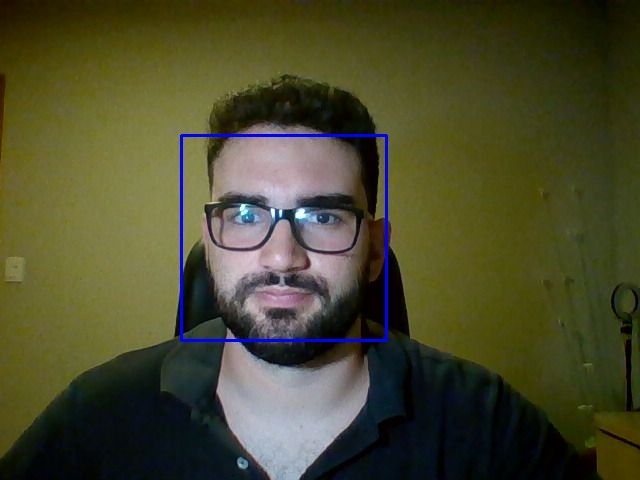

In [6]:
# Rodando a função take_photo

try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Exibir a imagem capturada
  display(Image(filename))
except Exception as err:
  # Erros serão exibidos se o usuário não tiver webcam disponível ou não autorizar o uso do dispositivo.
  print(str(err))

In [7]:
# Criando a função para a captura da webcam e detecção de faces para VIDEOS

# Para detecção de face em vídeos, é necessário criar uma live stream na webcam

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data



In [8]:
# Rodando a função de detecção para vídeo

# Iniciando o streaming na webcam
video_stream()

# label for video
label_html = 'Capturing...'

# Inicializando a bbox como variável vazia
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Converte JS para OpenCV
    img = js_to_image(js_reply["img"])

    # Cria camada transparente para bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Converte a imagem para niveis de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Obtém as coordenadas da face detectada
    faces = face_cascade.detectMultiScale(gray)

    # Cria a camada de sobreposição da bbox na imagem
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # Converte a camada da bbox para bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Atualizar a bbox para que o próximo quadro receba uma nova sobreposição
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

####**Detecção e Classificação das Imagens**


In [9]:
# Carregando as dependências
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import cv2

In [10]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# Reinicializar TensorFlow
import tensorflow as tf
tf.keras.backend.clear_session()

In [11]:
# Carregando o modelo pré-treinado

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [12]:
# Adicionar camadas personalizadas para reconhecimento facial
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)  # Altere para o número de classes desejado

model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
# Congelar as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# Compilar o modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print("✅ Modelo carregado e pronto para Fine-Tuning!")

✅ Modelo carregado e pronto para Fine-Tuning!


In [15]:
# Carregar a imagem salva e prepará-la para classificação
image_path = "/content/photo.jpg"

def classify_face(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("❌ Erro ao carregar a imagem!")
        return None

    image_resized = cv2.resize(image, (224, 224))  # Redimensionar para MobileNetV2
    image_array = np.expand_dims(image_resized, axis=0) / 255.0  # Normalizar
    prediction = model.predict(image_array)
    class_id = np.argmax(prediction)  # Obtém a classe predita
    return class_id

In [16]:
import tensorflow as tf
print("Versão do TensorFlow:", tf.__version__)
print("GPU Disponível:", tf.config.list_physical_devices('GPU'))


Versão do TensorFlow: 2.18.0
GPU Disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
# Rodar a classificação
predicted_class = classify_face(image_path)
if predicted_class is not None:
    print(f"🎯 Classe prevista: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
🎯 Classe prevista: 0
